In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Preproccesing

In [2]:
data = pd.read_csv('german_credit_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


Убираем Сhecking account, т.к. много пропусков  
Purpose не имеет смысла, т.к. есть стоимость кредита  
Sex тоже убираем, считая, что не самый важный признак

In [3]:
data.drop(['Unnamed: 0', 'Checking account', 'Purpose', 'Sex'], axis=1, inplace=True)

In [4]:
data.head()

,Age,Job,Housing,Saving accounts,Credit amount,Duration
0,67,2,own,NaN,1169,6
1,22,2,own,little,5951,48
2,49,1,own,little,2096,12
3,45,2,free,little,7882,42
4,53,2,free,little,4870,24


In [5]:
data.fillna('none', inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              1000 non-null   int64 
 1   Job              1000 non-null   int64 
 2   Housing          1000 non-null   object
 3   Saving accounts  1000 non-null   object
 4   Credit amount    1000 non-null   int64 
 5   Duration         1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


In [7]:
data.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [8]:
from sklearn.preprocessing import OrdinalEncoder

labels = ['Housing', 'Saving accounts']
for label in labels:
    data[label] = OrdinalEncoder().fit_transform(data[[label]])

In [9]:
data.head()

,Age,Job,Housing,Saving accounts,Credit amount,Duration
0,67,2,1.0,2.0,1169,6
1,22,2,1.0,0.0,5951,48
2,49,1,1.0,0.0,2096,12
3,45,2,0.0,0.0,7882,42
4,53,2,0.0,0.0,4870,24


В основе методов кластеризации лежит мера “близости” между различными объектами.  
Признаки отличаются и по типу распределения, и по диапазону.  
Чтобы можно было с ними работать, сравнивать, их нужно нормализовать.  
Причём так, чтобы ни у какого из них не было преимуществ перед другими.

In [10]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(data)

## EDA

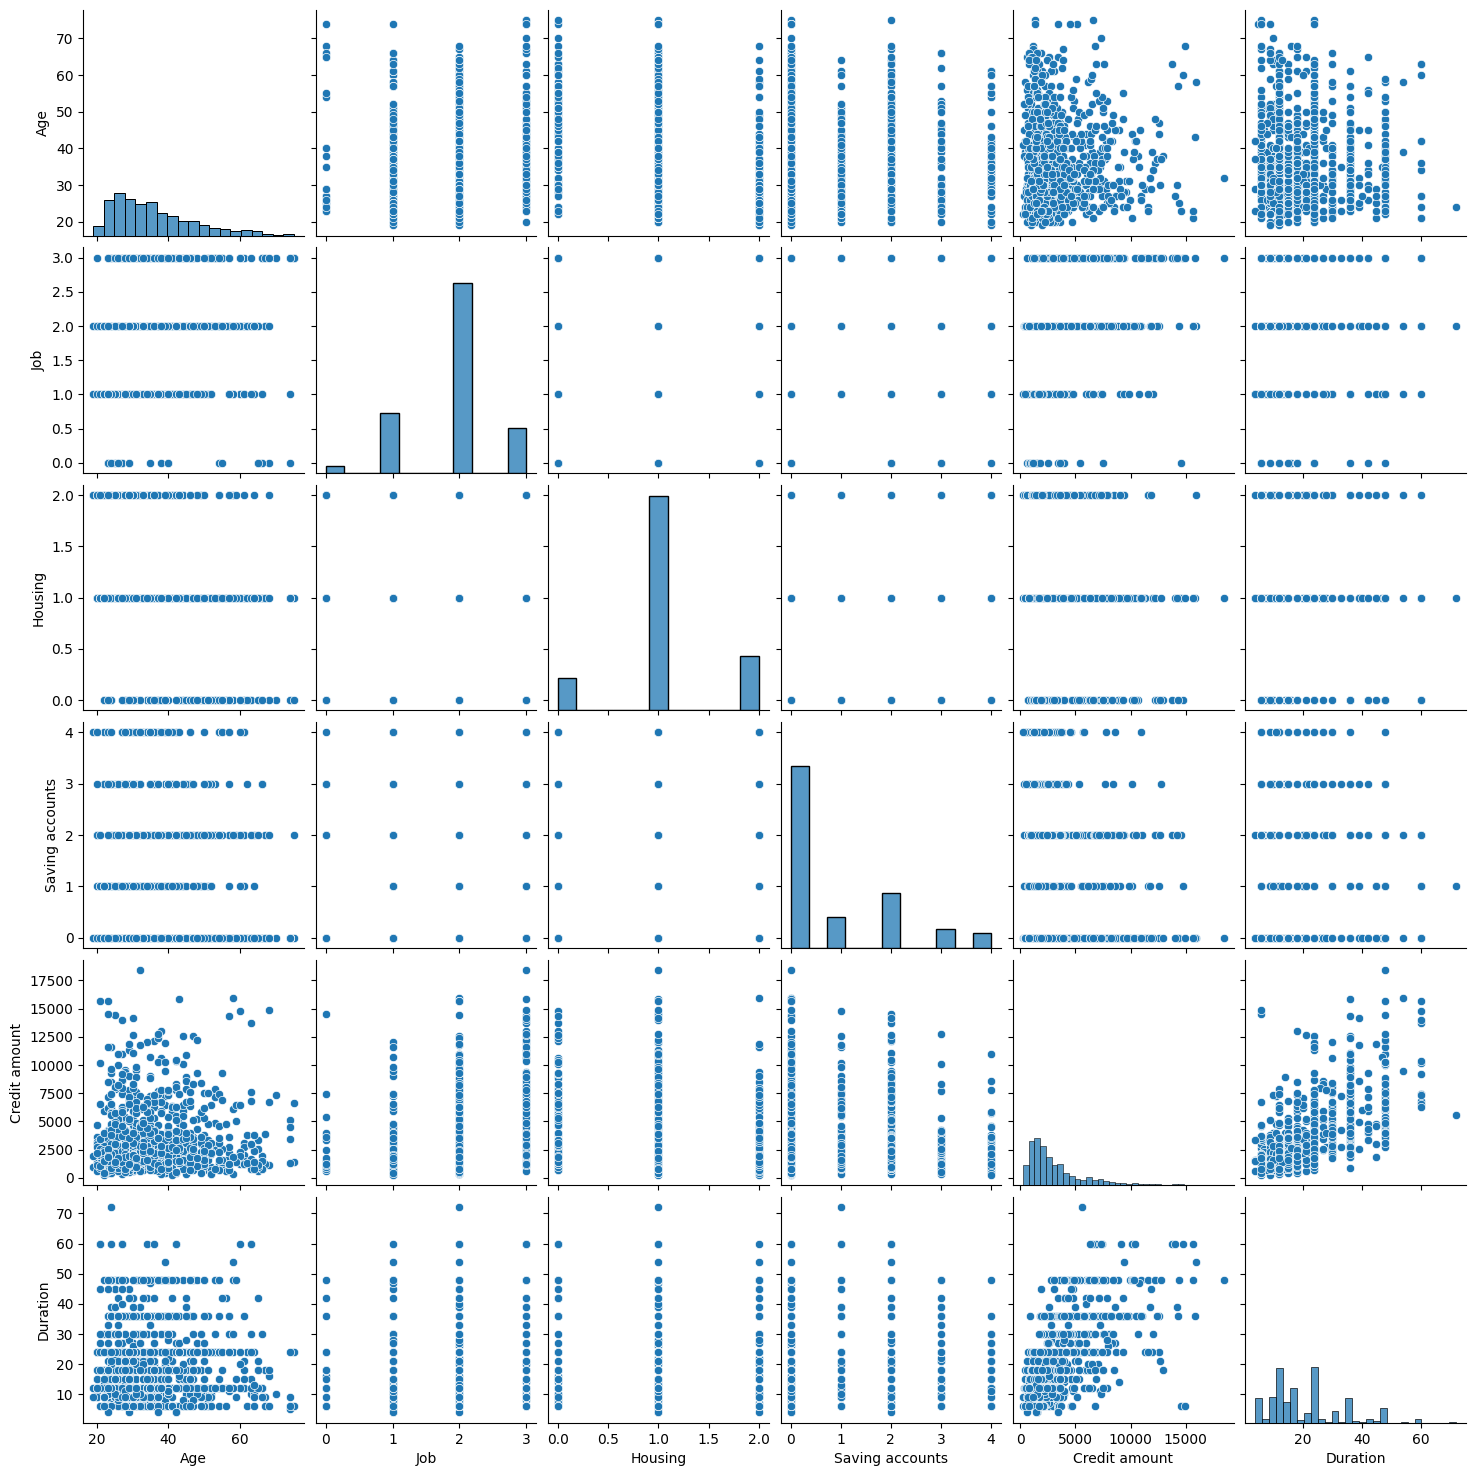

In [11]:
sns.pairplot(data)

<Axes: >

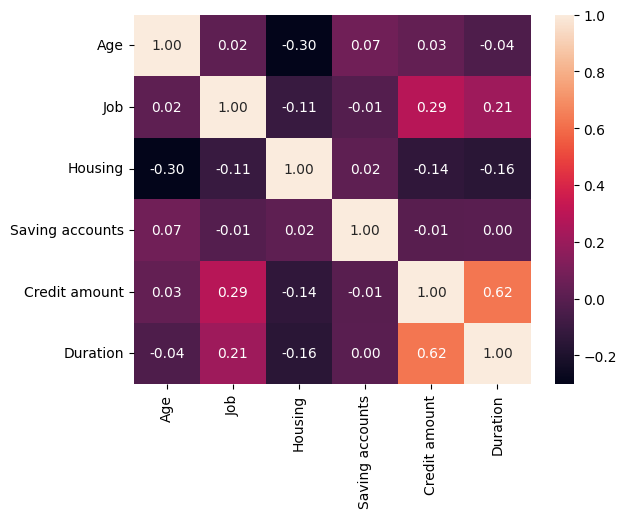

In [12]:
sns.heatmap(data.corr(), annot=True, fmt='.2f')

In [13]:
def plots_of_cluster(X_tsne, X_pca, X_umap, title=None, hue=None):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=hue, palette='rainbow', s=15)
    plt.title('TSNE')

    plt.subplot(1, 3, 2)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hue, palette='rainbow', s=15)
    plt.title('PCA')

    plt.subplot(1, 3, 3)
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=hue, palette='rainbow', s=15)
    plt.title('UMAP')

    plt.suptitle(title)

    plt.tight_layout()
    plt.show()



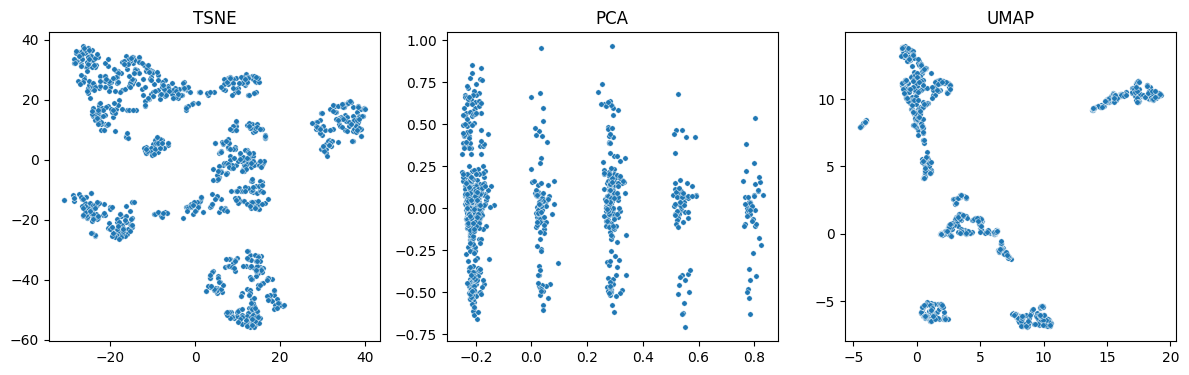

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_tsne = tsne.fit_transform(X)

pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

u = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
X_umap = u.fit_transform(X)

plots_of_cluster(X_tsne, X_pca, X_umap)

## KMeans

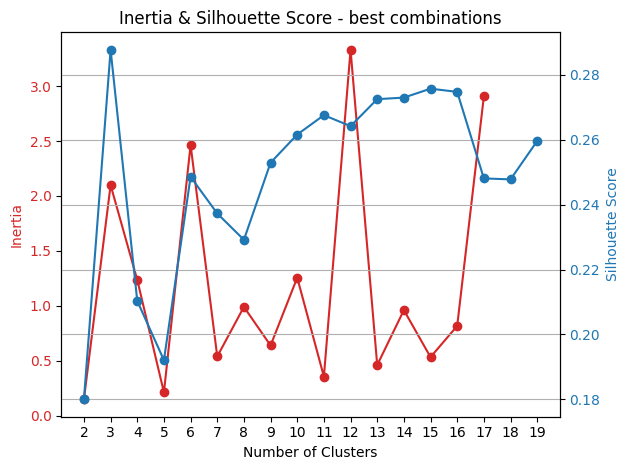

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusters = 20

inertia = []
score_kmeans = []
for n_clusters in np.arange(2, clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED).fit(X)
    
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

    clustering = kmeans.predict(X)
    silhouette = silhouette_score(X, clustering)
    score_kmeans.append(silhouette)

D = []
for i in range(1, clusters - 3):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
plt.xticks(np.arange(2, clusters, 1))
ax1.set_ylabel('Inertia', color=color )
ax1.plot(np.arange(2, clusters-2), D, marker='o', color=color )
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(np.arange(2, clusters), score_kmeans, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Inertia & Silhouette Score - best combinations')
plt.tight_layout()
plt.grid(True)
plt.show()

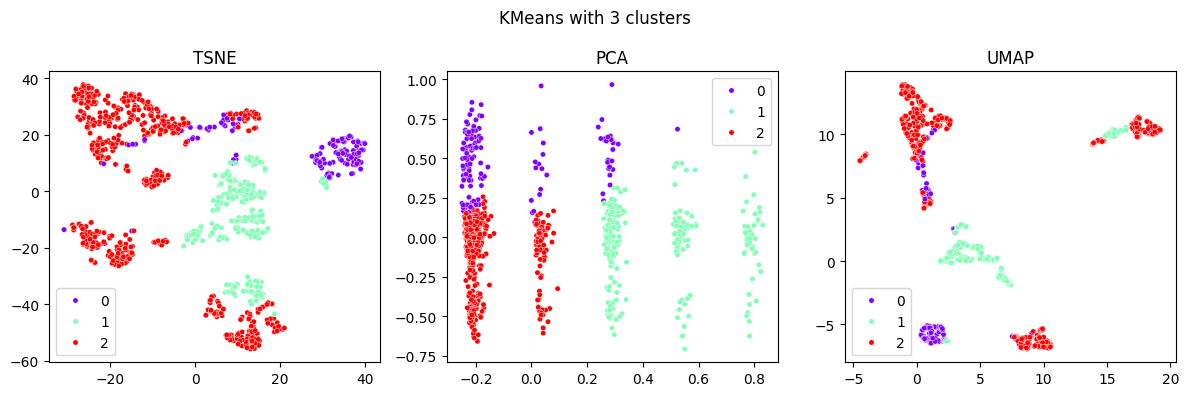

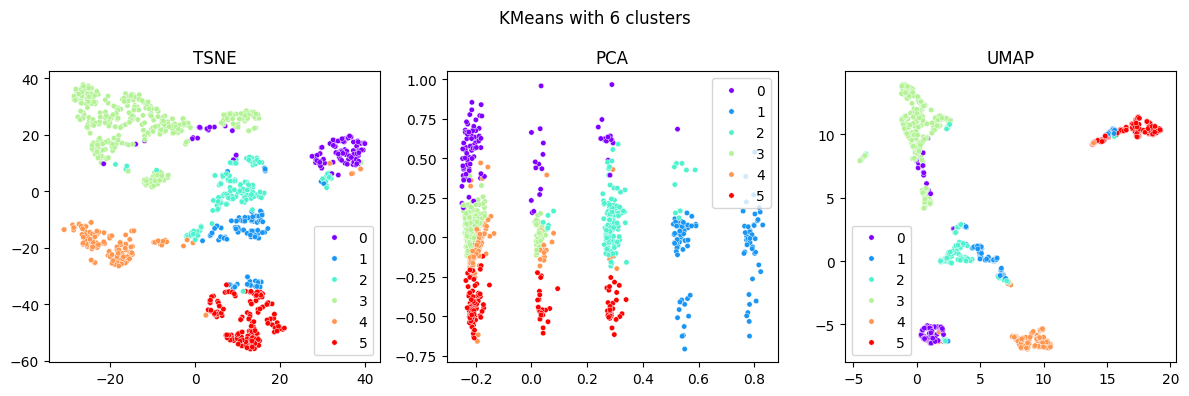

In [16]:
for n_clusters in [3, 6]:
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init='auto').fit(X)
    labels_kmeans = kmeans.labels_

    plots_of_cluster(X_tsne, X_pca, X_umap, title=f'KMeans with {n_clusters} clusters', hue=labels_kmeans)

## AgglomerativeClustering

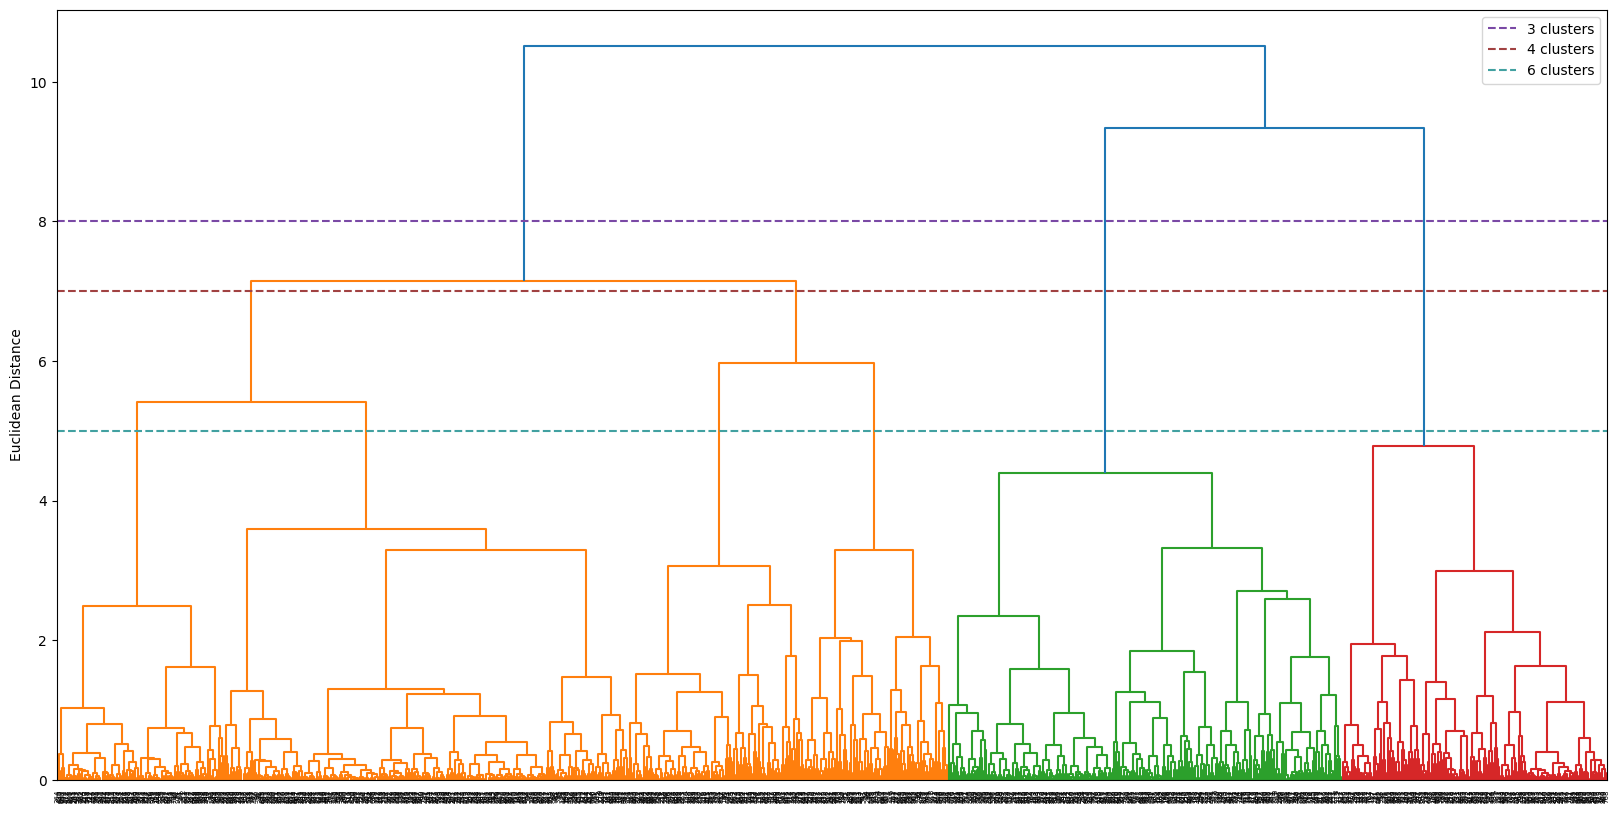

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(20,10))

linkage_ = linkage(X, method='ward')
dendrogram_ = dendrogram(linkage_)

plt.axhline(y=8, c='#7a49a5', linestyle='--', label='3 clusters')
plt.axhline(y=7, c='#a14242', linestyle='--', label='4 clusters')
plt.axhline(y=5, c='#42A1A1', linestyle='--', label='6 clusters')
plt.ylabel('Euclidean Distance')
plt.legend()
plt.show()

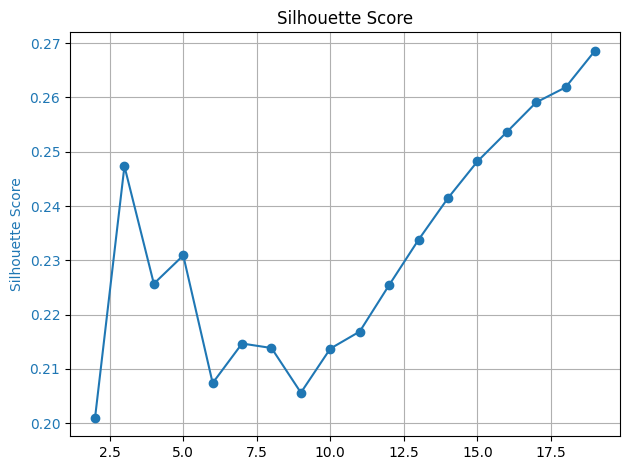

In [18]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

clusters = 20

silhouette = []
for n_clusters in np.arange(2, clusters):    
    agg = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    score = silhouette_score(X, agg.labels_)
    silhouette.append(score)

fig, ax = plt.subplots()

color = 'tab:blue'
ax.set_ylabel('Silhouette Score', color=color)
ax.plot(np.arange(2, clusters), silhouette, marker='o', color=color)
ax.tick_params(axis='y', labelcolor=color)

plt.title('Silhouette Score')
plt.tight_layout()
plt.grid(True)
plt.show()

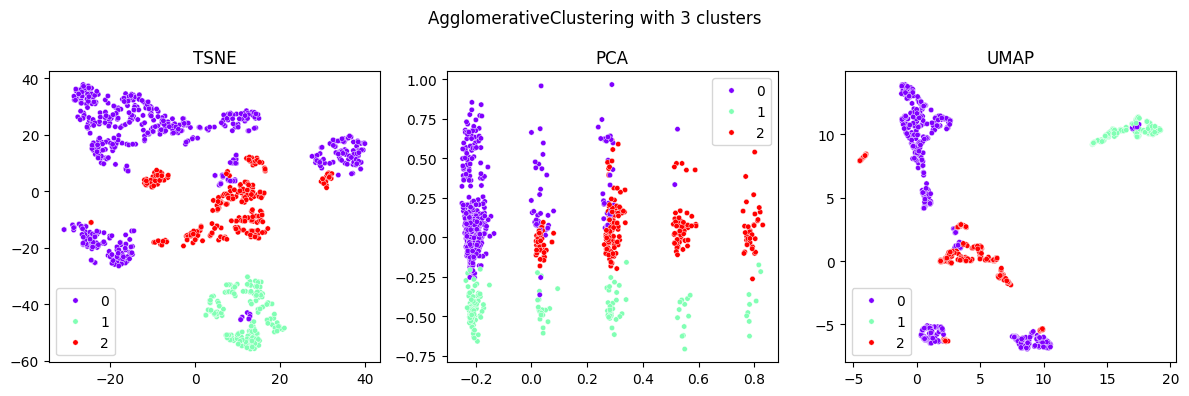

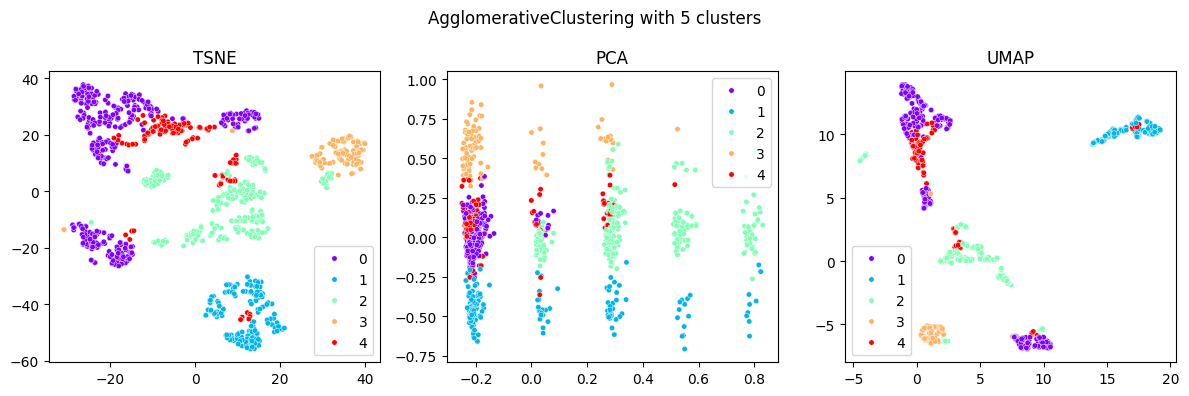

In [19]:
for n_clusters in [3, 5]:
    agg = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    labels_agg = agg.labels_

    plots_of_cluster(X_tsne, X_pca, X_umap, title=f'AgglomerativeClustering with {n_clusters} clusters', hue=labels_agg)

## DBSCAN

In [20]:

from sklearn.cluster import  DBSCAN
from tqdm import tqdm

def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i, min_samples=5).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

100%|██████████| 9/9 [00:01<00:00,  7.54it/s]


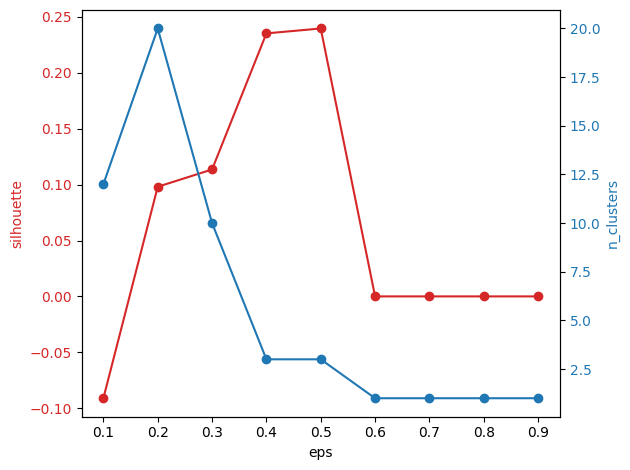

In [21]:
eps_range = np.arange(0.1,1,0.1)
dbscan_clustering(eps_range, X)

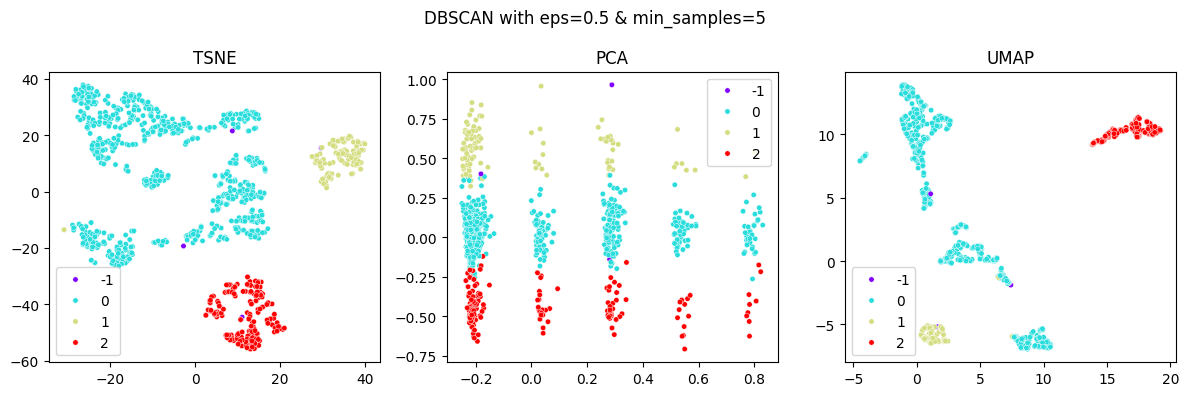

In [23]:
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X)
labels_dbscan = dbscan.labels_
plots_of_cluster(X_tsne, X_pca, X_umap, title='DBSCAN with eps=0.5 & min_samples=5', hue=labels_dbscan)

## Interpretation

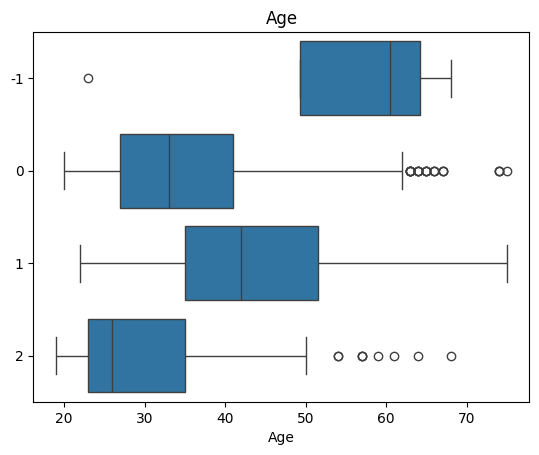

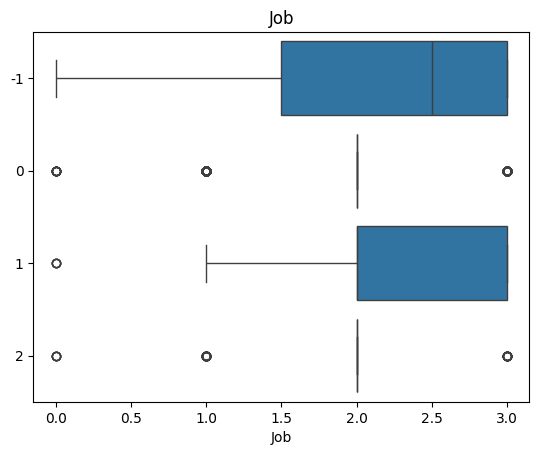

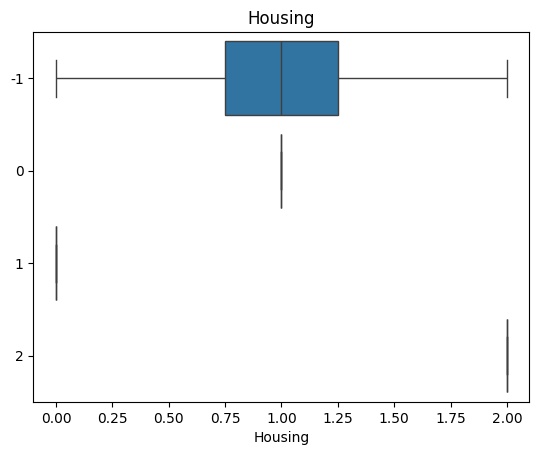

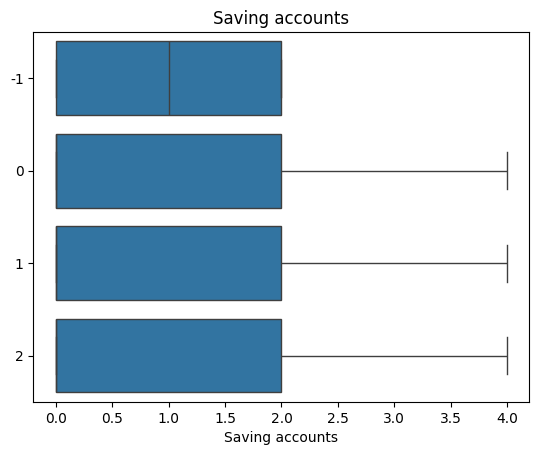

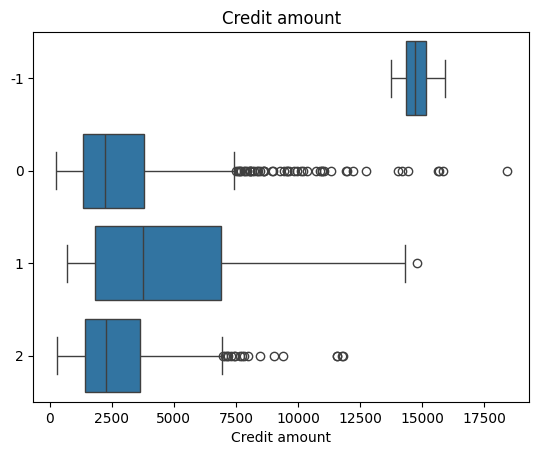

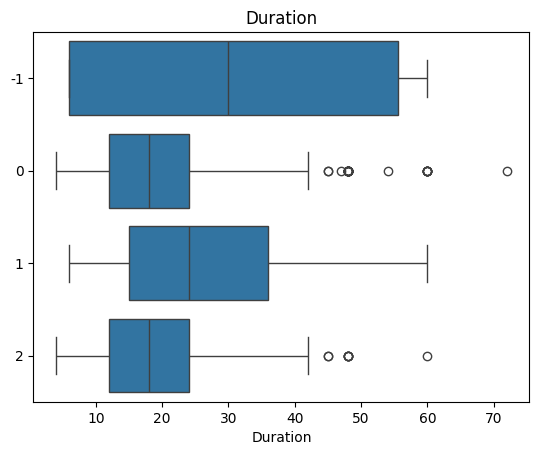

In [24]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels_dbscan, orient='h')
    plt.title(col)
    plt.show()

# Первый кластер  
Возраст: 27 - 40 лет (средний)  
Работа: skilled  
Жилье: own  
Сумма кредита: берут средний кредит  
Срок кредита: в основном 1 - 2 года  

# Второй кластер  
Возраст: 35 - 52 лет (высокий)  
Работа: skilled and high skilled  
Жилье: free  
Сумма кредита: берут большой кредит  
Срок кредита: берут на длительный срок  

# Третий кластер
Возраст: 23 - 35 лет (низкий)  
Работа: skilled  
Жилье: rent
Сумма кредита: берут средний кредит  
Срок кредита: берут в основоном 1-2 года